İmport some useful packages and increase the default figure size.

In [6]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import numpy as np
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [5]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/home/basak/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
x_train, y_train, x_test, y_test = eecs598.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


Visualize the dataset

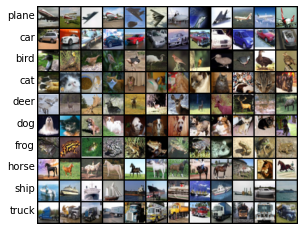

In [5]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(eecs598.tensor_to_image(img))
plt.axis('off')
plt.show()

The label data is just a list of 10,000 numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.

airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9

In [8]:
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [9]:
y_train=train_labels.flatten()
y_test=test_labels.flatten()
# We have reduced the dimension

In [10]:
x_train=tf.image.rgb_to_grayscale(train_images)
x_test=tf.image.rgb_to_grayscale(test_images)
#to convert grayscale

Filter the dataset to keep just the cat  and frog, remove the other classes

In [11]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [12]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 10000
Number of filtered test examples: 2000


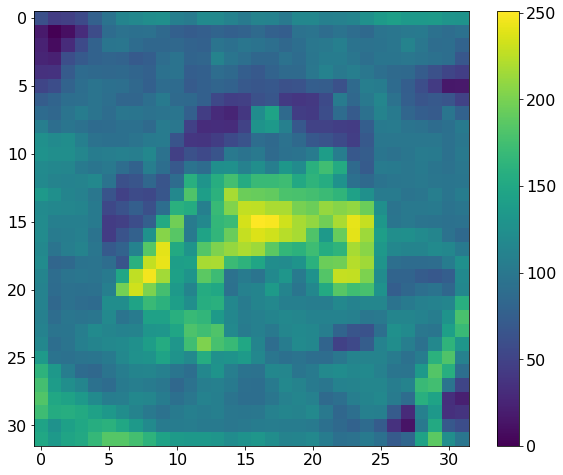

In [13]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

 Resize the image 36x36 to down to 4x4

In [22]:
x_train_s = tf.image.resize(x_train, (3,3)).numpy()
x_test_s = tf.image.resize(x_test, (3,3)).numpy()

## Encode the data as quantum circuits

The first step is to convert to a binary encoding.

In [31]:

THRESHOLD = 0.5

x_train_bin = np.array(x_train_s > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_s > THRESHOLD, dtype=np.float32)

The qubits at pixel indices with values that exceed a threshold, are rotated through an gate.

In [30]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(6, 6)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.H(qubits[i]))

    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


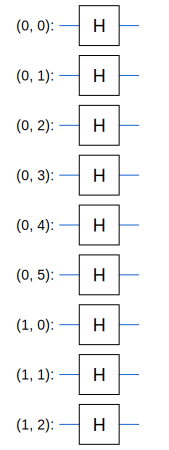

In [32]:
SVGCircuit(x_train_circ[0])


Convert  Cirq circuits to tensors for tfq

In [35]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## Quantum neural network

add a layer of these gates to a circuit

In [37]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)


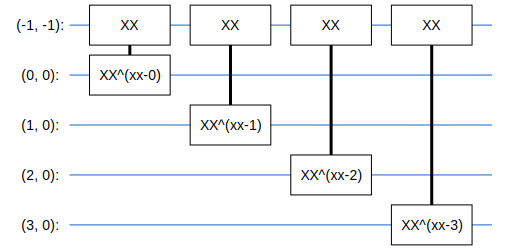

In [38]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)


In [39]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [40]:
model_circuit, model_readout = create_quantum_model()


 Build the Keras model.


In [45]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [46]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0


In [47]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [49]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])



In [50]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
EPOCHS = 3
BATCH_SIZE = 128

NUM_EXAMPLES = len(x_train_tfcirc)



In [52]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]



In [53]:
import time
start_time = time.time()

In [54]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)



Epoch 1/3
313/313 [==============================] - 2197s 7s/step - loss: 1.0000 - hinge_accuracy: 0.4995 - val_loss: 1.0000 - val_hinge_accuracy: 0.5010
Epoch 2/3
313/313 [==============================] - 2225s 7s/step - loss: 1.0000 - hinge_accuracy: 0.4996 - val_loss: 1.0000 - val_hinge_accuracy: 0.5010
Epoch 3/3
63/63 [==============================] - 55s 877ms/step - loss: 1.0000 - hinge_accuracy: 0.5015


In [55]:
qnn_accuracy = qnn_results[1]
qnn_accuracy


0.5014880895614624

In [56]:
model.predict_classes(x_train_tfcirc[0:7])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

/home/basak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


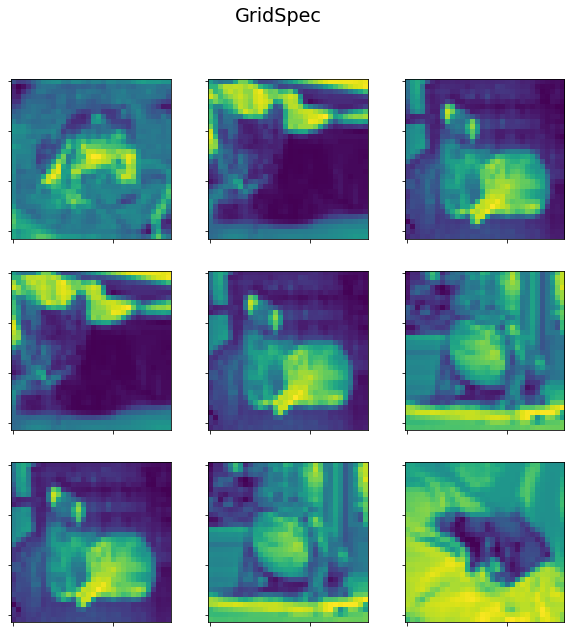

In [57]:


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    
    ax.imshow(x_train[i+j, :, :, 0])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()



In [ ]:
plt.plot(qnn_history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()